# Generate a PV diagram using PVExtractor following this tutorial:
#### https://learn.astropy.org/tutorials/PVDiagramPlotting.html

In [1]:
import pylab as plt
import numpy as np
from astropy.visualization import quantity_support
from astropy import units as u
from astropy import wcs
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.patheffects as pe


# set so that these display properly on black backgrounds
#plt.rcParams['figure.facecolor']='w'

from spectral_cube import SpectralCube

from pvextractor import extract_pv_slice, Path, PathFromCenter

### First use the scattered light image to get the vector along which we'll generate the PV diagram

In [2]:
# then load in the C18O data cube which is needed to obtain the velocities

spectral_cube = SpectralCube.read('/Users/kristina/Hamburgers/Draculas_Chivito/SMA/data/DraChi.briggs0.C18O.velcor.lsrk.im.image_modified_header.fits')

spectral_cube = spectral_cube.with_spectral_unit(unit=u.km/u.s, rest_value=219.56035*u.GHz, velocity_convention='radio')
spectral_cube._unit = u.Jy/u.beam

spectral_cube

VaryingResolutionSpectralCube with shape=(60, 144, 144) and unit=Jy / beam:
 n_x:    144  type_x: RA---SIN  unit_x: deg    range:   347.406190 deg:  347.457880 deg
 n_y:    144  type_y: DEC--SIN  unit_y: deg    range:    67.384148 deg:   67.404009 deg
 n_s:     60  type_s: VRAD      unit_s: km / s  range:      -22.506 km / s:      -0.006 km / s

## Repeat the same analysis but now compute the PV diagram along the C18O channel map

In [3]:
# load in the PS1 g-band image which we need to identify the disk's midplane

mom0_file = '/Users/kristina/Hamburgers/Draculas_Chivito/SMA/data/DraChi.briggs0.C18O.velcor.lsrk.im.image_M0.fits'
mom0 = fits.open(mom0_file)

wcs_mom0 = WCS(mom0[0].header)
mom0_data = mom0[0].data
mom0_header = mom0[0].header



/Users/kristina/miniconda3/lib/python3.10/site-packages/radio_beam/multiple_beams.py:286: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/kristina/miniconda3/lib/python3.10/site-packages/spectral_cube/spectral_cube.py:441: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


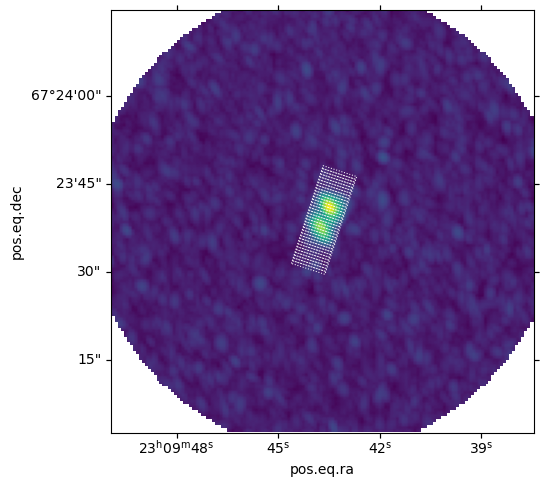

In [4]:
### Now adjust the right ascension such that it aligns with the "major axis" of the C18O emission

# First, take the same vector as in the scattered light image (as this one safely constrains the position angle)
ra_cen = 347.4318*u.deg 
dec_cen = 67.3942*u.deg 

# Notes: The orientation of the final path will be such that for a position angle of zero, the path goes from South to North. 
# For a position angle of 90 degrees, the path will go from West to East.
# sample : How many points to sample along the path. By default, this is 2 (the two end points)
# width : The width of the path
# https://pvextractor.readthedocs.io/en/latest/api/pvextractor.PathFromCenter.html
Path2 = PathFromCenter(center=SkyCoord(ra_cen, dec_cen, frame='fk5'), length=18.*u.arcsec, angle=342*u.deg, sample=2, width=6.*u.arcsec)
#Path2 = PathFromCenter(center=SkyCoord(347.4318*u.deg , 67.3942*u.deg , frame='fk5'), length=18.*u.arcsec, angle=342*u.deg, sample=2, width=2.*u.arcsec)


plt.figure(figsize=(12,6))
ax = plt.subplot(121, projection=spectral_cube.wcs.celestial)
ax.imshow(spectral_cube.max(axis=0).value)
Path2.show_on_axis(ax=ax, spacing=1, edgecolor='w', linestyle=':', linewidth=0.75)
#Path3.show_on_axis(ax=ax, spacing=1, edgecolor='red', linestyle=':', linewidth=0.75)

### Now we can compute the pv diagram:


In [5]:
# spacing gives the separation between these points in pixels; we finely sampled by picking one-pixel spacing.
pvdiagram2 = extract_pv_slice(cube=spectral_cube, path=Path2, spacing=1.)

/Users/kristina/miniconda3/lib/python3.10/site-packages/radio_beam/multiple_beams.py:286: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/kristina/miniconda3/lib/python3.10/site-packages/spectral_cube/spectral_cube.py:441: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


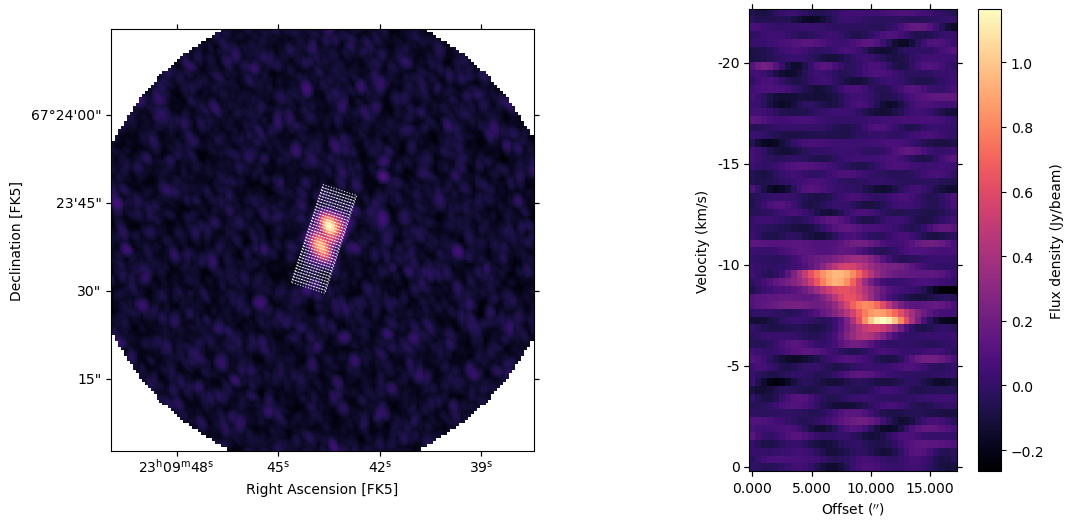

In [6]:
# plot the results and check if they make sense

from matplotlib.colors import SymLogNorm, LogNorm

plt.figure(figsize=(12,6))

# first show vector on PS1 g-band
ax = plt.subplot(121, projection=wcs_mom0)

ax.imshow(spectral_cube.max(axis=0).value, cmap='magma')
Path2.show_on_axis(ax=ax, spacing=1, edgecolor='w', linestyle=':', linewidth=0.75)


# then show the PV diagram
ww2 = wcs.WCS(pvdiagram2.header)
ax.set_xlabel(f"Right Ascension [FK5]")
ax.set_ylabel(f"Declination [FK5]")

ax = plt.subplot(122, projection=ww2)
im = ax.imshow(pvdiagram2.data, cmap='magma')

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcsec)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s)
cb = plt.colorbar(mappable=im)

cb.set_label("Flux density (Jy/beam)")
ax.set_ylabel("Velocity (km/s)")
ax.set_xlabel("Offset ($''$)")
ax.set_aspect(1.3)

#ax.set_ylim(23, 50)

## Now overplot the Keplerian velocity profile for different disk masses

In [7]:
### First define Keplerian velocity

import astropy.constants as const
import astropy.units as u

def kepler(mass, radius, distance, inclination):#, PA=342.):
    """
    mass in solar masses
    radius in arcsec
    distance in pc
    inclination in degrees
    """
    G = const.G
    mass *= u.Msun
    physical_radius = (radius*distance)*u.au
    
    return np.sqrt(G*mass/physical_radius).to(u.km/u.s)*np.sin(inclination*u.deg)#*np.cos(PA*u.deg)

In [8]:
pvdiagram2.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   35                                                  
NAXIS2  =                   60                                                  
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                  1.0 / Pixel coordinate of reference point            
CRPIX2  =                  1.0 / Pixel coordinate of reference point            
CDELT1  =   0.0001388888888889 / [deg] Coordinate increment at reference point  
CDELT2  =     -381.35800324589 / [m/s] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'm/s'                / Units of coordinate increment and value        
CTYPE1  = 'OFFSET'          

In [9]:
# get pixel scales
pos_zero = pvdiagram2.header['CRVAL1'] # 0 deg
vel_zero = pvdiagram2.header['CRVAL2']/1000. #5.2016146231858 km/s

pos_pixscale = pvdiagram2.header['CDELT1']*60.*60. # arcsec per pixel
vel_pixscale = pvdiagram2.header['CDELT2']/1000. #-0.36319867699999997 km/s per pixel

pos_offset = pos_zero/pos_pixscale
vel_offset = vel_zero/vel_pixscale


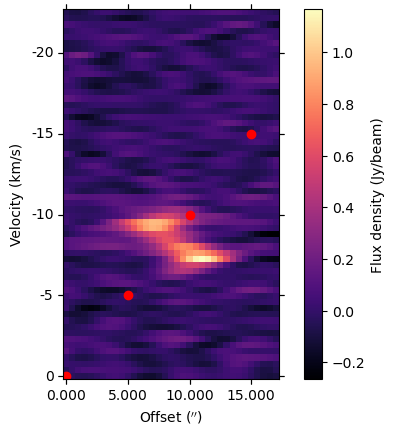

In [10]:
ax = plt.subplot(111, projection=ww2)

im = ax.imshow(pvdiagram2.data, cmap='magma')

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcsec)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s)
cb = plt.colorbar(mappable=im)

cb.set_label("Flux density (Jy/beam)")
ax.set_ylabel("Velocity (km/s)")
ax.set_xlabel("Offset ($''$)")
#ax.set_aspect(1)



ax.scatter(0/pos_pixscale, 0/vel_pixscale-vel_offset, c='red')
ax.scatter(5/pos_pixscale, (-5/vel_pixscale)-vel_offset, c='red')
ax.scatter(10/pos_pixscale, (-10/vel_pixscale)-vel_offset, c='red')
ax.scatter(15/pos_pixscale, (-15/vel_pixscale)-vel_offset, c='red')


#ax.set_ylim(23, 50)
#ax.axhline(40, c='white', lw=3, zorder=2)

/Users/kristina/miniconda3/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


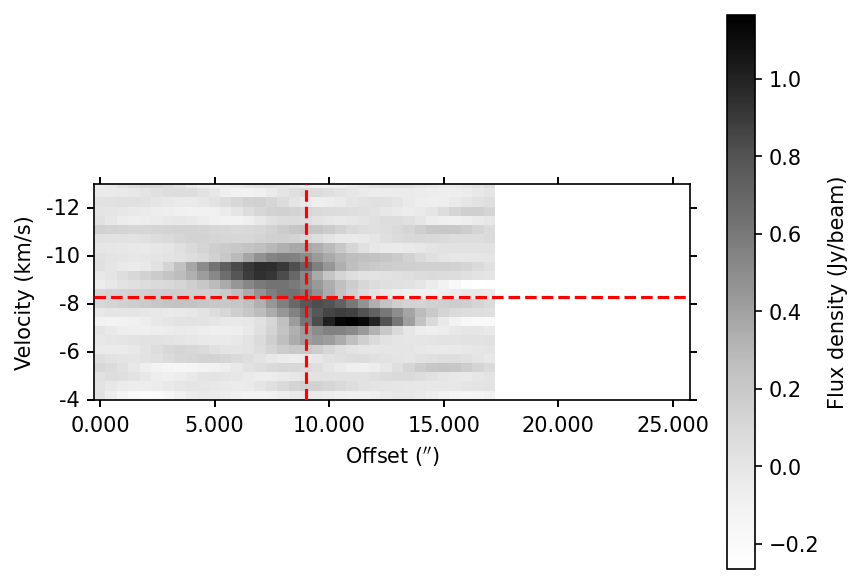

In [11]:
plt.figure(dpi=150)

ax = plt.subplot(111, projection=ww2)

im = ax.imshow(pvdiagram2.data, cmap='Greys', origin='lower')

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcsec)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s)
cb = plt.colorbar(mappable=im)

cb.set_label("Flux density (Jy/beam)")
ax.set_ylabel("Velocity (km/s)")
ax.set_xlabel("Offset ($''$)")
ax.set_aspect(0.8)

v_sys = -8.3*u.km/u.s # got this value from eddy
x_mid = 9. #arcsec; length of the vector is 18 arcsec

ax.set_ylim(-4/vel_pixscale-vel_offset, -13/vel_pixscale-vel_offset)

plt.axhline((v_sys.value/vel_pixscale)-vel_offset, c='red', ls='--')
plt.axvline((x_mid/pos_pixscale)-pos_offset, c='red', ls='--')

radii_pos = np.linspace(0,20,1000)
radii_pixelscale = radii_pos/pos_pixscale

colors = plt.cm.rainbow_r(np.linspace(0, 1, len(np.arange(1,4.5,0.5))))

# rainbow_r colormap starts at red
masses = np.arange(1,4.5,0.5)

plt.plot(radii_pixelscale+x_mid, (kepler(mass=1.0, radius=radii_pos, distance=370., inclination=80.).value)/vel_pixscale+vel_offset)

#for el in range(len(masses)):
    #ax.plot(radii_pixelscale-pos_offset, (v_sys.value/vel_pixscale-vel_offset)+kepler(mass=np.round(masses[el],2), radius=radii_pos, distance=370., inclination=80.).value/vel_pixscale-vel_offset, c=colors[el], alpha=0.3, lw=2)
    #ax.plot(-radii_pixelscale-pos_offset, (v_sys.value/vel_pixscale-vel_offset)-kepler(mass=np.round(masses[el],2), radius=radii_pos, distance=370., inclination=80.).value/vel_pixscale-vel_offset, c=colors[el], alpha=0.3, lw=2)

#ax.plot(PVpix_neg, (v_sys-kepler(mass=2.0, radius=np.abs(PVpix_neg.value), distance=370., inclination=80.)))


#ax.set_ylim(23, 50)
#ax.axhline(40, c='white', lw=3, zorder=2)

### First: create our own grid that is not in pixel units (because otherwise one would have to convert everything physical into pixel units)

In [12]:
# check the dimensions of the PV diagram
ww2

WCS Keywords

Number of WCS axes: 2
CTYPE : 'OFFSET'  'VRAD'  
CRVAL : 0.0  -5.5982288140823  
CRPIX : 1.0  1.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.0001388888888889  -381.35800324589  
NAXIS : 35  60

#### create a pixel grid first and convert this into physical units

In [13]:
pvdiagram2.data.shape

(60, 35)

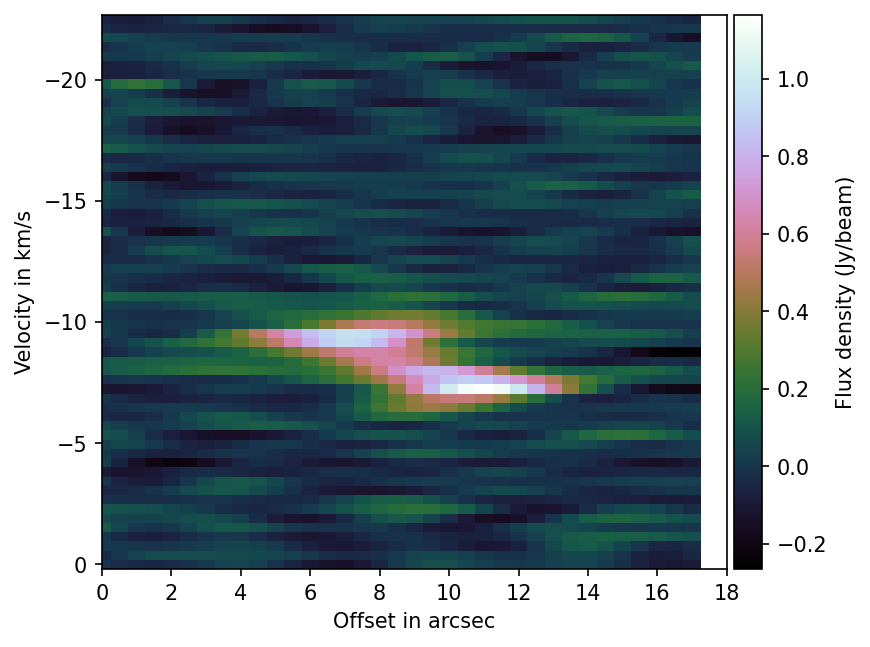

In [14]:
v_sys = -8.3 #u.km/u.s # got this value from eddy
pos_mid = 9. #arcsec; length of the vector is 18 arcsec

# x-axis has len=35
vel_arr = np.linspace(0,34,35)*pos_pixscale# + pos_zero - x_mid 
# y-axis has len=60
pos_arr = np.linspace(0,59,60)*vel_pixscale# + vel_zero# - v_sys

xi, yi = np.meshgrid(vel_arr, pos_arr)
zi = pvdiagram2.data

plt.figure(dpi=150)

plt.pcolormesh(xi, yi, zi.reshape(yi.shape), cmap='cubehelix')

plt.gca().invert_yaxis()

plt.xlabel('Offset in arcsec')
plt.ylabel('Velocity in km/s')

plt.xlim(0,18)


# rainbow_r colormap starts at red
colors = plt.cm.rainbow_r(np.linspace(0, 1, len(np.arange(1,4.5,0.5))))
masses = np.arange(1,4.5,0.5)
radii = np.linspace(0,20,1000) #arcsec

cb = plt.colorbar(pad=0.01)
cb.set_label("Flux density (Jy/beam)", fontsize=10)


#### Now plot "offset" axes instead of strictly increasing axes

In [15]:
vel_zero

-0.0055982288140823

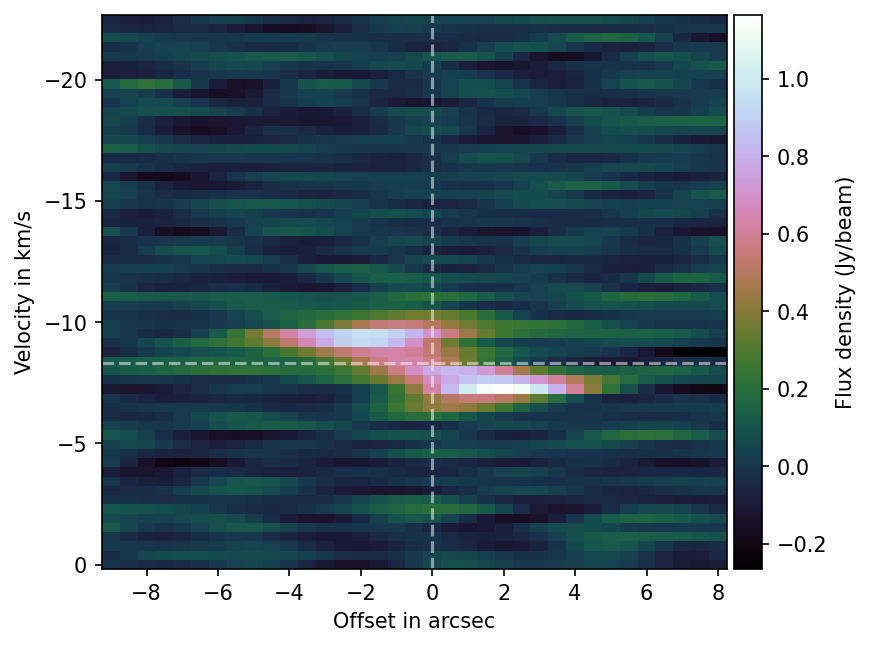

In [16]:
v_sys = -8.3 #u.km/u.s # got this value from eddy
pos_mid = 9. #arcsec; length of the vector is 18 arcsec

# x-axis has len=35
vel_arr = np.linspace(0,34,35)*pos_pixscale + pos_zero - x_mid 
# y-axis has len=60
pos_arr = np.linspace(0,59,60)*vel_pixscale + vel_zero# - v_sys

xi, yi = np.meshgrid(vel_arr, pos_arr)
zi = pvdiagram2.data

plt.figure(dpi=150)

plt.pcolormesh(xi, yi, zi.reshape(yi.shape), cmap='cubehelix')

plt.gca().invert_yaxis()

plt.xlabel('Offset in arcsec')
plt.ylabel('Velocity in km/s')

# rainbow_r colormap starts at red
masses = np.arange(1,5,1)
colors = plt.cm.rainbow_r(np.linspace(0, 1, len(masses)))
radii = np.linspace(0,20,1000) #arcsec

# overplot Kepler velocity profiles
#for el in range(len(masses)):
#    plt.plot(radii, kepler(mass=np.round(masses[el],2), radius=radii, distance=370., inclination=80.).value+v_sys, c=colors[el], alpha=0.6, lw=2)
#    plt.plot(-radii, -kepler(mass=np.round(masses[el],2), radius=radii, distance=370., inclination=80.).value+v_sys, c=colors[el], alpha=0.6, lw=2)

plt.axhline(v_sys, c='white', ls='--', alpha=0.5)
plt.axvline(0, c='white', ls='--', alpha=0.5)


cb = plt.colorbar(pad=0.01)
cb.set_label("Flux density (Jy/beam)", fontsize=10)


/Users/kristina/miniconda3/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


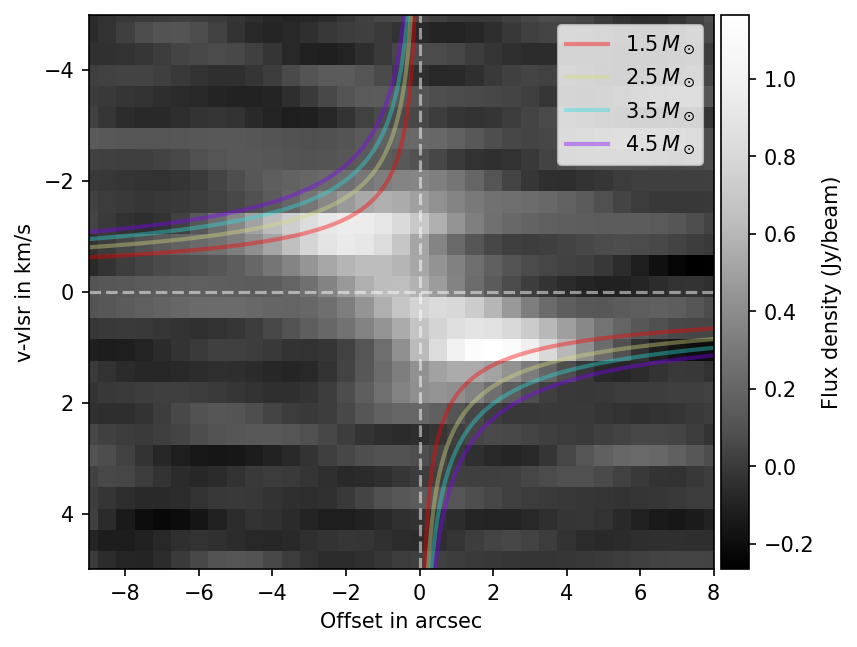

In [20]:
v_sys = -8.3 #u.km/u.s # got this value from eddy
pos_mid = 9. #arcsec; length of the vector is 18 arcsec

# x-axis has len=35
vel_arr = np.linspace(0,34,35)*pos_pixscale + pos_zero - x_mid 
# y-axis has len=60
pos_arr = np.linspace(0,59,60)*vel_pixscale + vel_zero - v_sys

xi, yi = np.meshgrid(vel_arr, pos_arr)
zi = pvdiagram2.data

plt.figure(dpi=150)

plt.pcolormesh(xi, yi, zi.reshape(yi.shape), cmap='Greys_r')

plt.gca().invert_yaxis()

plt.xlabel('Offset in arcsec')
plt.ylabel('v-vlsr in km/s')

# rainbow_r colormap starts at red
masses = np.arange(1.5,5.5,1)
colors = plt.cm.rainbow_r(np.linspace(0, 1, len(masses)))
radii = np.linspace(0,20,1000) #arcsec

# overplot Kepler velocity profiles
for el in range(len(masses)):
    plt.plot(radii, kepler(mass=np.round(masses[el],2), radius=radii, distance=370., inclination=80.).value, c=colors[el], alpha=0.4, lw=2, label='{0}$\,M_\odot$'.format(np.round(masses[el],2)))
    plt.plot(-radii, -kepler(mass=np.round(masses[el],2), radius=radii, distance=370., inclination=80.).value, c=colors[el], alpha=0.4, lw=2)

plt.axhline(0, c='white', ls='--', alpha=0.5)
plt.axvline(0, c='white', ls='--', alpha=0.5)

plt.ylim(5, -5)
plt.xlim(-9,+8)

plt.legend()


cb = plt.colorbar(pad=0.01)
cb.set_label("Flux density (Jy/beam)", fontsize=10)


In [21]:
import pyspeckit
from astropy.wcs import wcs
data_file = fits.open('/Users/kristina/Hamburgers/Draculas_Chivito/SMA/data/DraChi.briggs0.C18O.velcor.lsrk.im.image_modified_header.fits')[0]
data, header = data_file.data, data_file.header

x_center = 347.432
y_center = 67.3942
w = wcs.WCS(header, naxis=(1,2))

#Convert center value to pixel coordinates
pixcrd = w.wcs_world2pix(np.vstack((x_center,y_center)).T, 1)[0]

#xwidth and ywidth are radii in pixel units of the data cube
cutout_cube = pyspeckit.cubes.subcube(spectral_cube, xcen=pixcrd[0], ycen=pixcrd[1], xwidth=30, ywidth=30)


This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
This function (<function BaseSpectralCube.max at 0x135377880>) requires loading the entire cube into memory and may therefore be slow.
Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
Arithmetic beam averaging is being performed.  This is not a mathematically robust operation, but is being permitted because the beams differ by <0.01
divide by zero encountered in divide


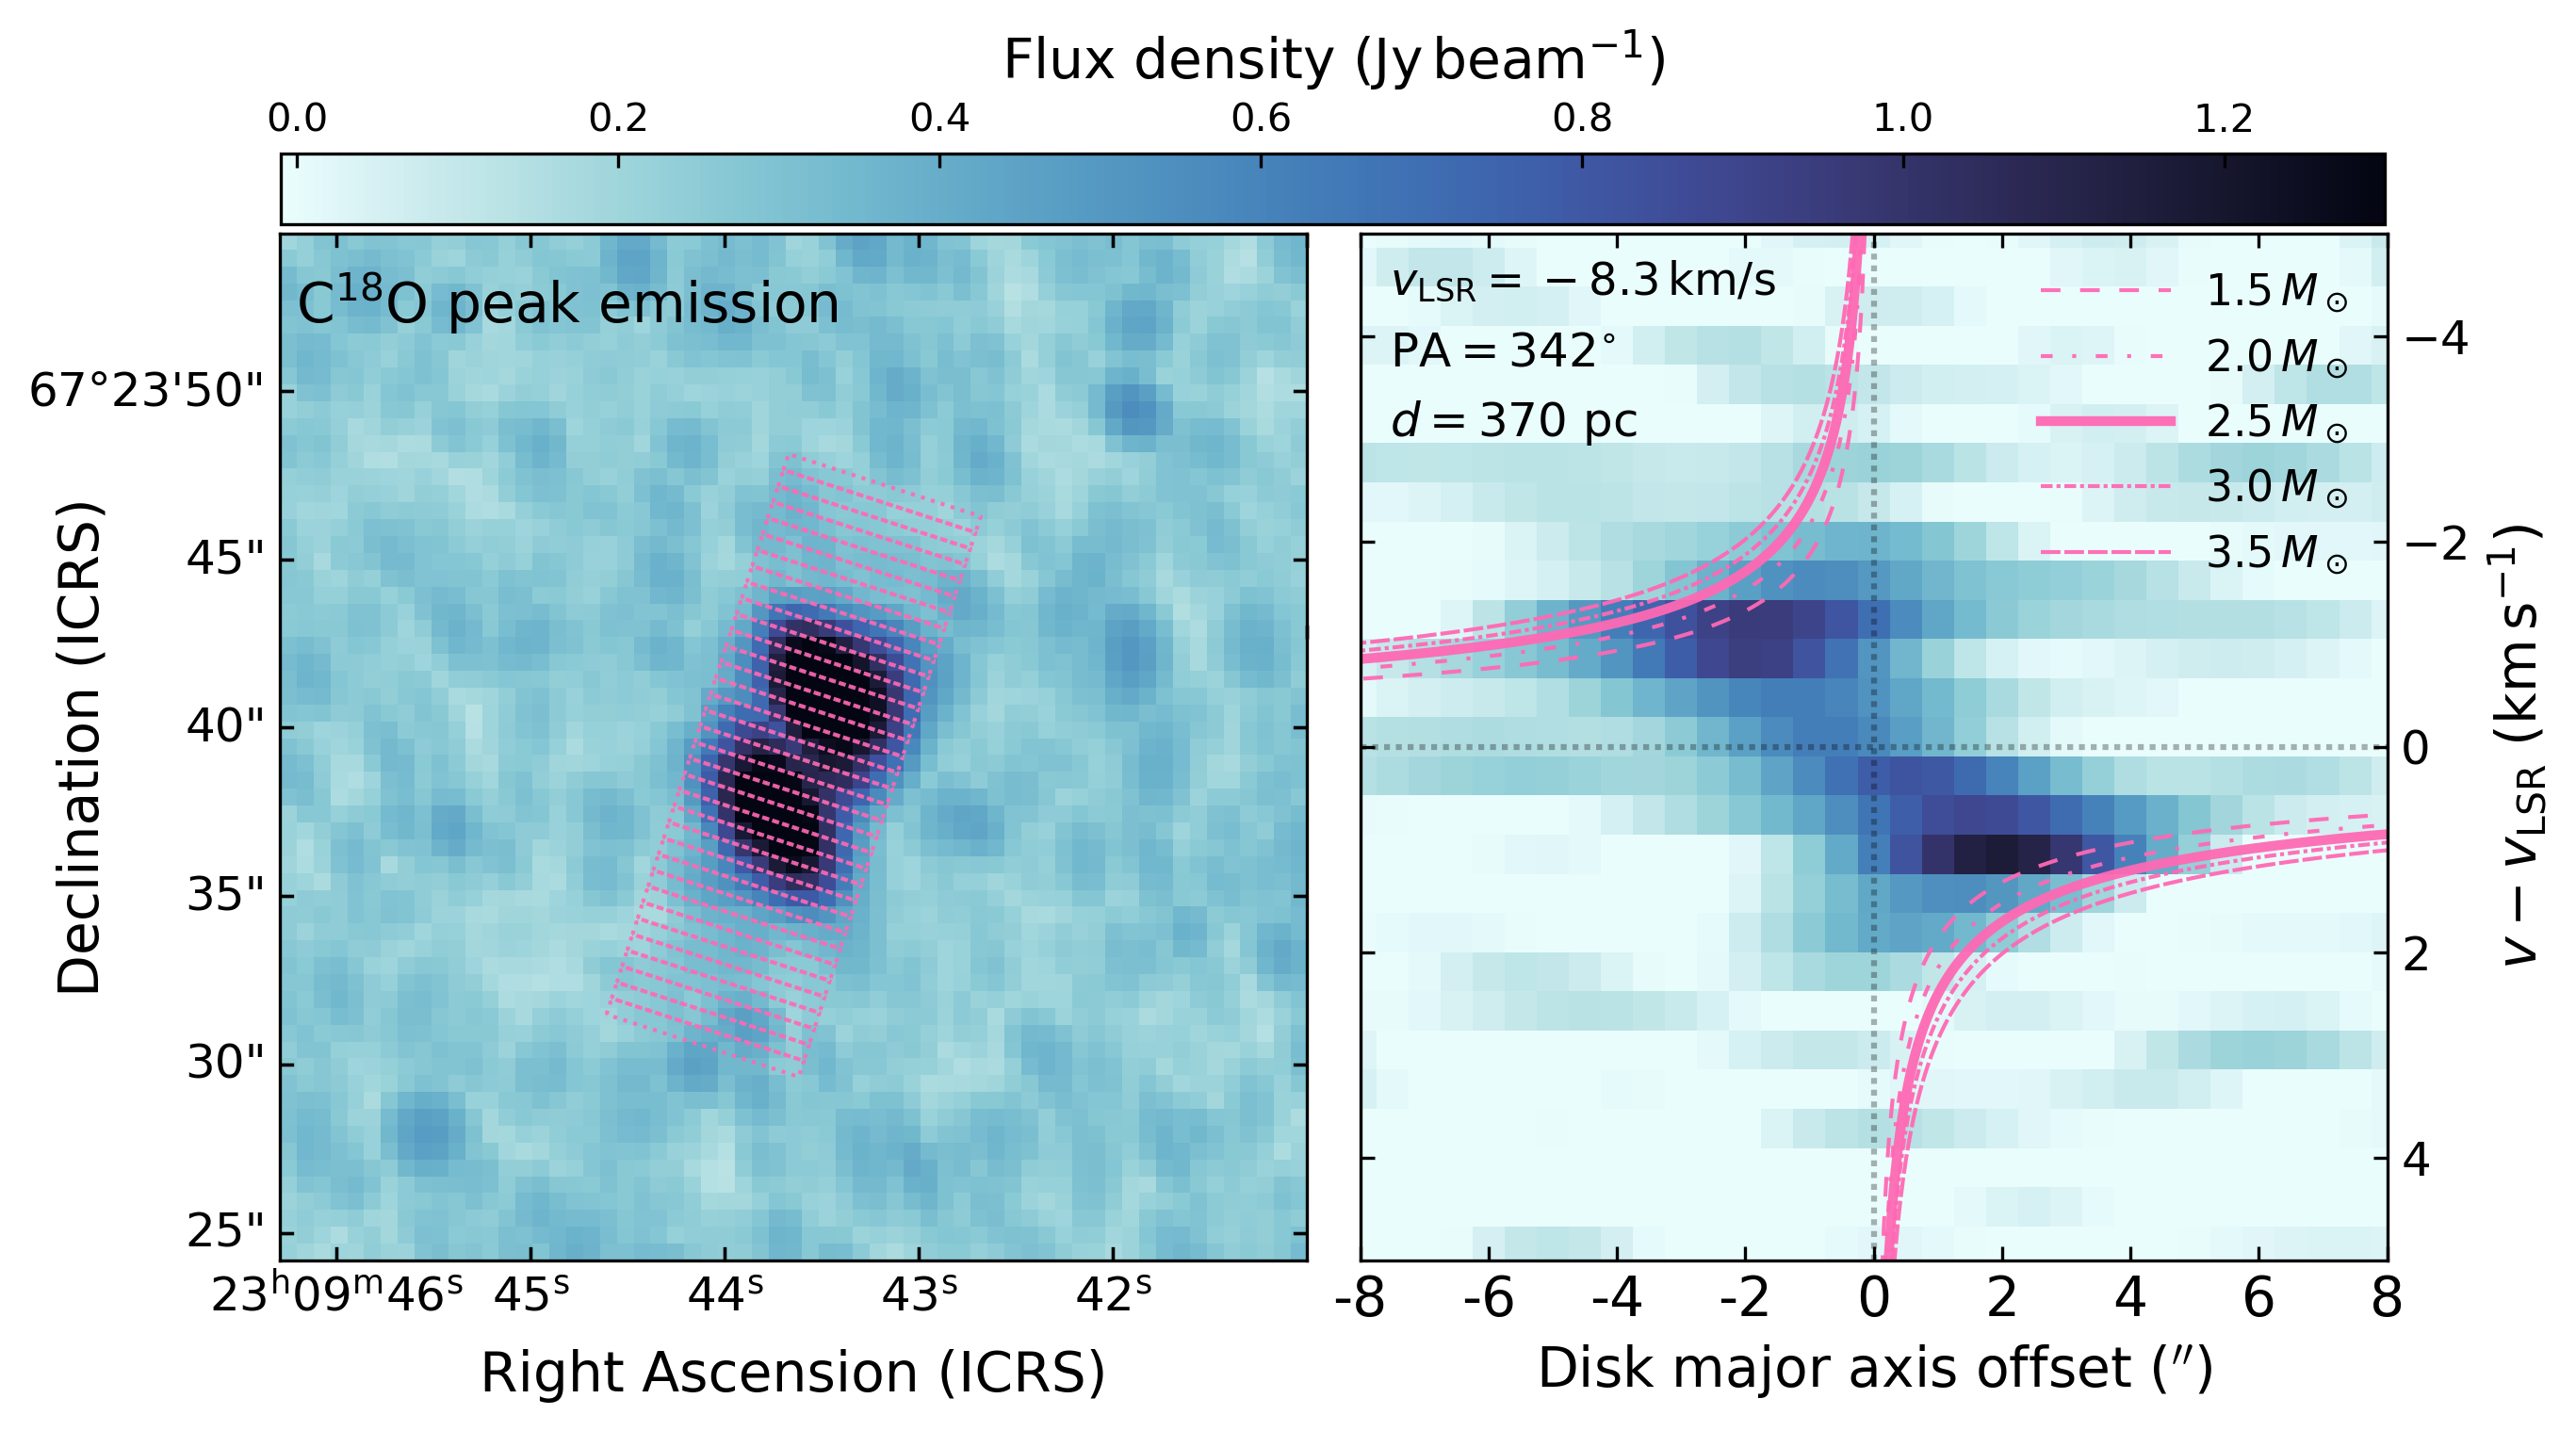

In [29]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cmocean 
import cmasher as cmr
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

### C18O peak emission
#color_table = plt.get_cmap('cmr.eclipse')   # MPL
color_table=cmocean.cm.ice_r
# so the slit is plotted on the scattered light image BUT the pv diagram was computed along the spectral cube


fig = plt.figure(layout="constrained", dpi=300, figsize=(9,5))
fig.subplots_adjust(wspace=0.05)

gs = GridSpec(1, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0], projection=cutout_cube.wcs.celestial)
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[0, 1])


ax1.tick_params(axis="both", direction="in")

vmin, vmax = -0.01, 1.3
ax1.imshow(cutout_cube.max(axis=0).value, cmap=color_table, vmin=vmin, vmax=vmax)
Path2.show_on_axis(ax=ax1, spacing=1, edgecolor='hotpink', linestyle=':', linewidth=1, alpha=0.9)

ww = wcs.WCS(cutout_cube[0].header)
ax1.set_xlabel(f"Right Ascension (ICRS)", fontsize=14)
ax1.set_ylabel(f"Declination (ICRS)", fontsize=14, labelpad=-1)

ax1.tick_params(axis='both', which='both', color='black', labelsize=12)
fig. text(0.11,0.85, s='C$^{18}$O peak emission', c='black', size=14)


### PV diagram
v_sys = -8.3 #u.km/u.s # got this value from eddy
pos_mid = 9. #arcsec; length of the vector is 18 arcsec

# x-axis has len=35
vel_arr = np.linspace(0,34,35)*pos_pixscale + pos_zero - x_mid 
# y-axis has len=60
pos_arr = np.linspace(0,59,60)*vel_pixscale + vel_zero - v_sys

xi, yi = np.meshgrid(vel_arr, pos_arr)
zi = pvdiagram2.data

im = ax2.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=color_table, linewidth=0,rasterized=True, vmin=vmin, vmax=vmax)

ax2.invert_yaxis()

ax2.set_xlabel("Disk major axis offset ($''$)", fontsize=14)
ax2.set_ylabel(r"$v-v_\mathrm{LSR}$ (km$\,\mathrm{{s}}^{{-1}}$)", fontsize=14)

ax2.axvline(0, c='black', ls=(0, (1, 1)), alpha=0.3)
ax2.axhline(0, c='black', ls=(0, (1, 1)), alpha=0.3)

ax2.set_ylim(5,-5)
ax2.set_xlim(8, -8)

ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.tick_params(axis='both', which='both', direction="in", left=True, right=True, top=True, bottom=True, color='black', labelsize=12)

ax2.set_aspect(1.6)

ax2.set_xticks(np.arange(-8,10,2), labels=np.arange(-8,10,2), fontsize=14)
#ax2.set_xticks([-4.4,-6.4, -8.5, -10.4, -12.4], labels=['+4', '+2', '0', '-2', '-4' ], fontsize=14)
ax2.invert_xaxis()

# rainbow_r colormap starts at red
#cmr.neon
masses = np.arange(1.5,4,0.5)
colors = ['hotpink', 'hotpink', 'hotpink', 'hotpink', 'hotpink']
radii = np.linspace(0,20,1000) #arcsec

linestyles = [(0, (5, 5)), (0, (3, 5, 1, 5)), '-', (0, (3, 1, 1, 1)), (0, (5, 1))]
linewidths = [1,1,2.5,1,1]
 
# overplot Kepler velocity profiles
for el in range(len(masses)):
    plt.plot(radii, kepler(mass=np.round(masses[el],2), radius=radii, distance=370., inclination=80.), c=colors[el], alpha=0.95, lw=linewidths[el], ls=linestyles[el], label='${0}\,M_\odot$'.format(np.round(masses[el],2)))#, path_effects=[pe.Stroke(linewidth=3, foreground='white'), pe.Normal()])
    plt.plot(-radii, -kepler(mass=np.round(masses[el],2), radius=radii, distance=370., inclination=80.), c=colors[el], alpha=0.95, lw=linewidths[el], ls=linestyles[el])#, path_effects=[pe.Stroke(linewidth=3, foreground='white'), pe.Normal()])

ax2.legend(loc='upper right', framealpha=0., labelcolor='black', fontsize=11, handlelength=3)

cb_ax = fig.add_axes([0.104, 0.92, 0.827, 0.05]) #right, top, length, thickness, 
cbar = fig.colorbar(im, cax=cb_ax, orientation='horizontal')
cbar.ax.tick_params(axis='x', direction='in')
cbar.ax.xaxis.set_ticks_position("top")
cbar.set_label('Flux density $(\mathrm{Jy\,beam^{-1}})$', fontsize=14, labelpad=-50)

#cb = fig.colorbar(im, ax=ax2, orientation='horizontal', pad=-10)
#cb.set_label(label='Flux density $(\mathrm{Jy\,beam}^{-1}$)', fontsize=13)
fig.text(0.54,0.87, s=r'$v_\mathrm{{LSR}}={0}\,\mathrm{{km/s}}$'.format(v_sys), c='black', size=11.5)
fig.text(0.54,0.82, s=r'PA$=342^{{\circ}}$', c='black', size=12)
fig.text(0.54,0.77, s=r'$d=370$ pc', c='black', size=12)


#fig.tight_layout()

fig.savefig('../plots/paper_plots/pv_diagram_C18O.pdf', bbox_inches='tight')


This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
This function (<function BaseSpectralCube.max at 0x135377880>) requires loading the entire cube into memory and may therefore be slow.
Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
Arithmetic beam averaging is being performed.  This is not a mathematically robust operation, but is being permitted because the beams differ by <0.01
divide by zero encountered in divide


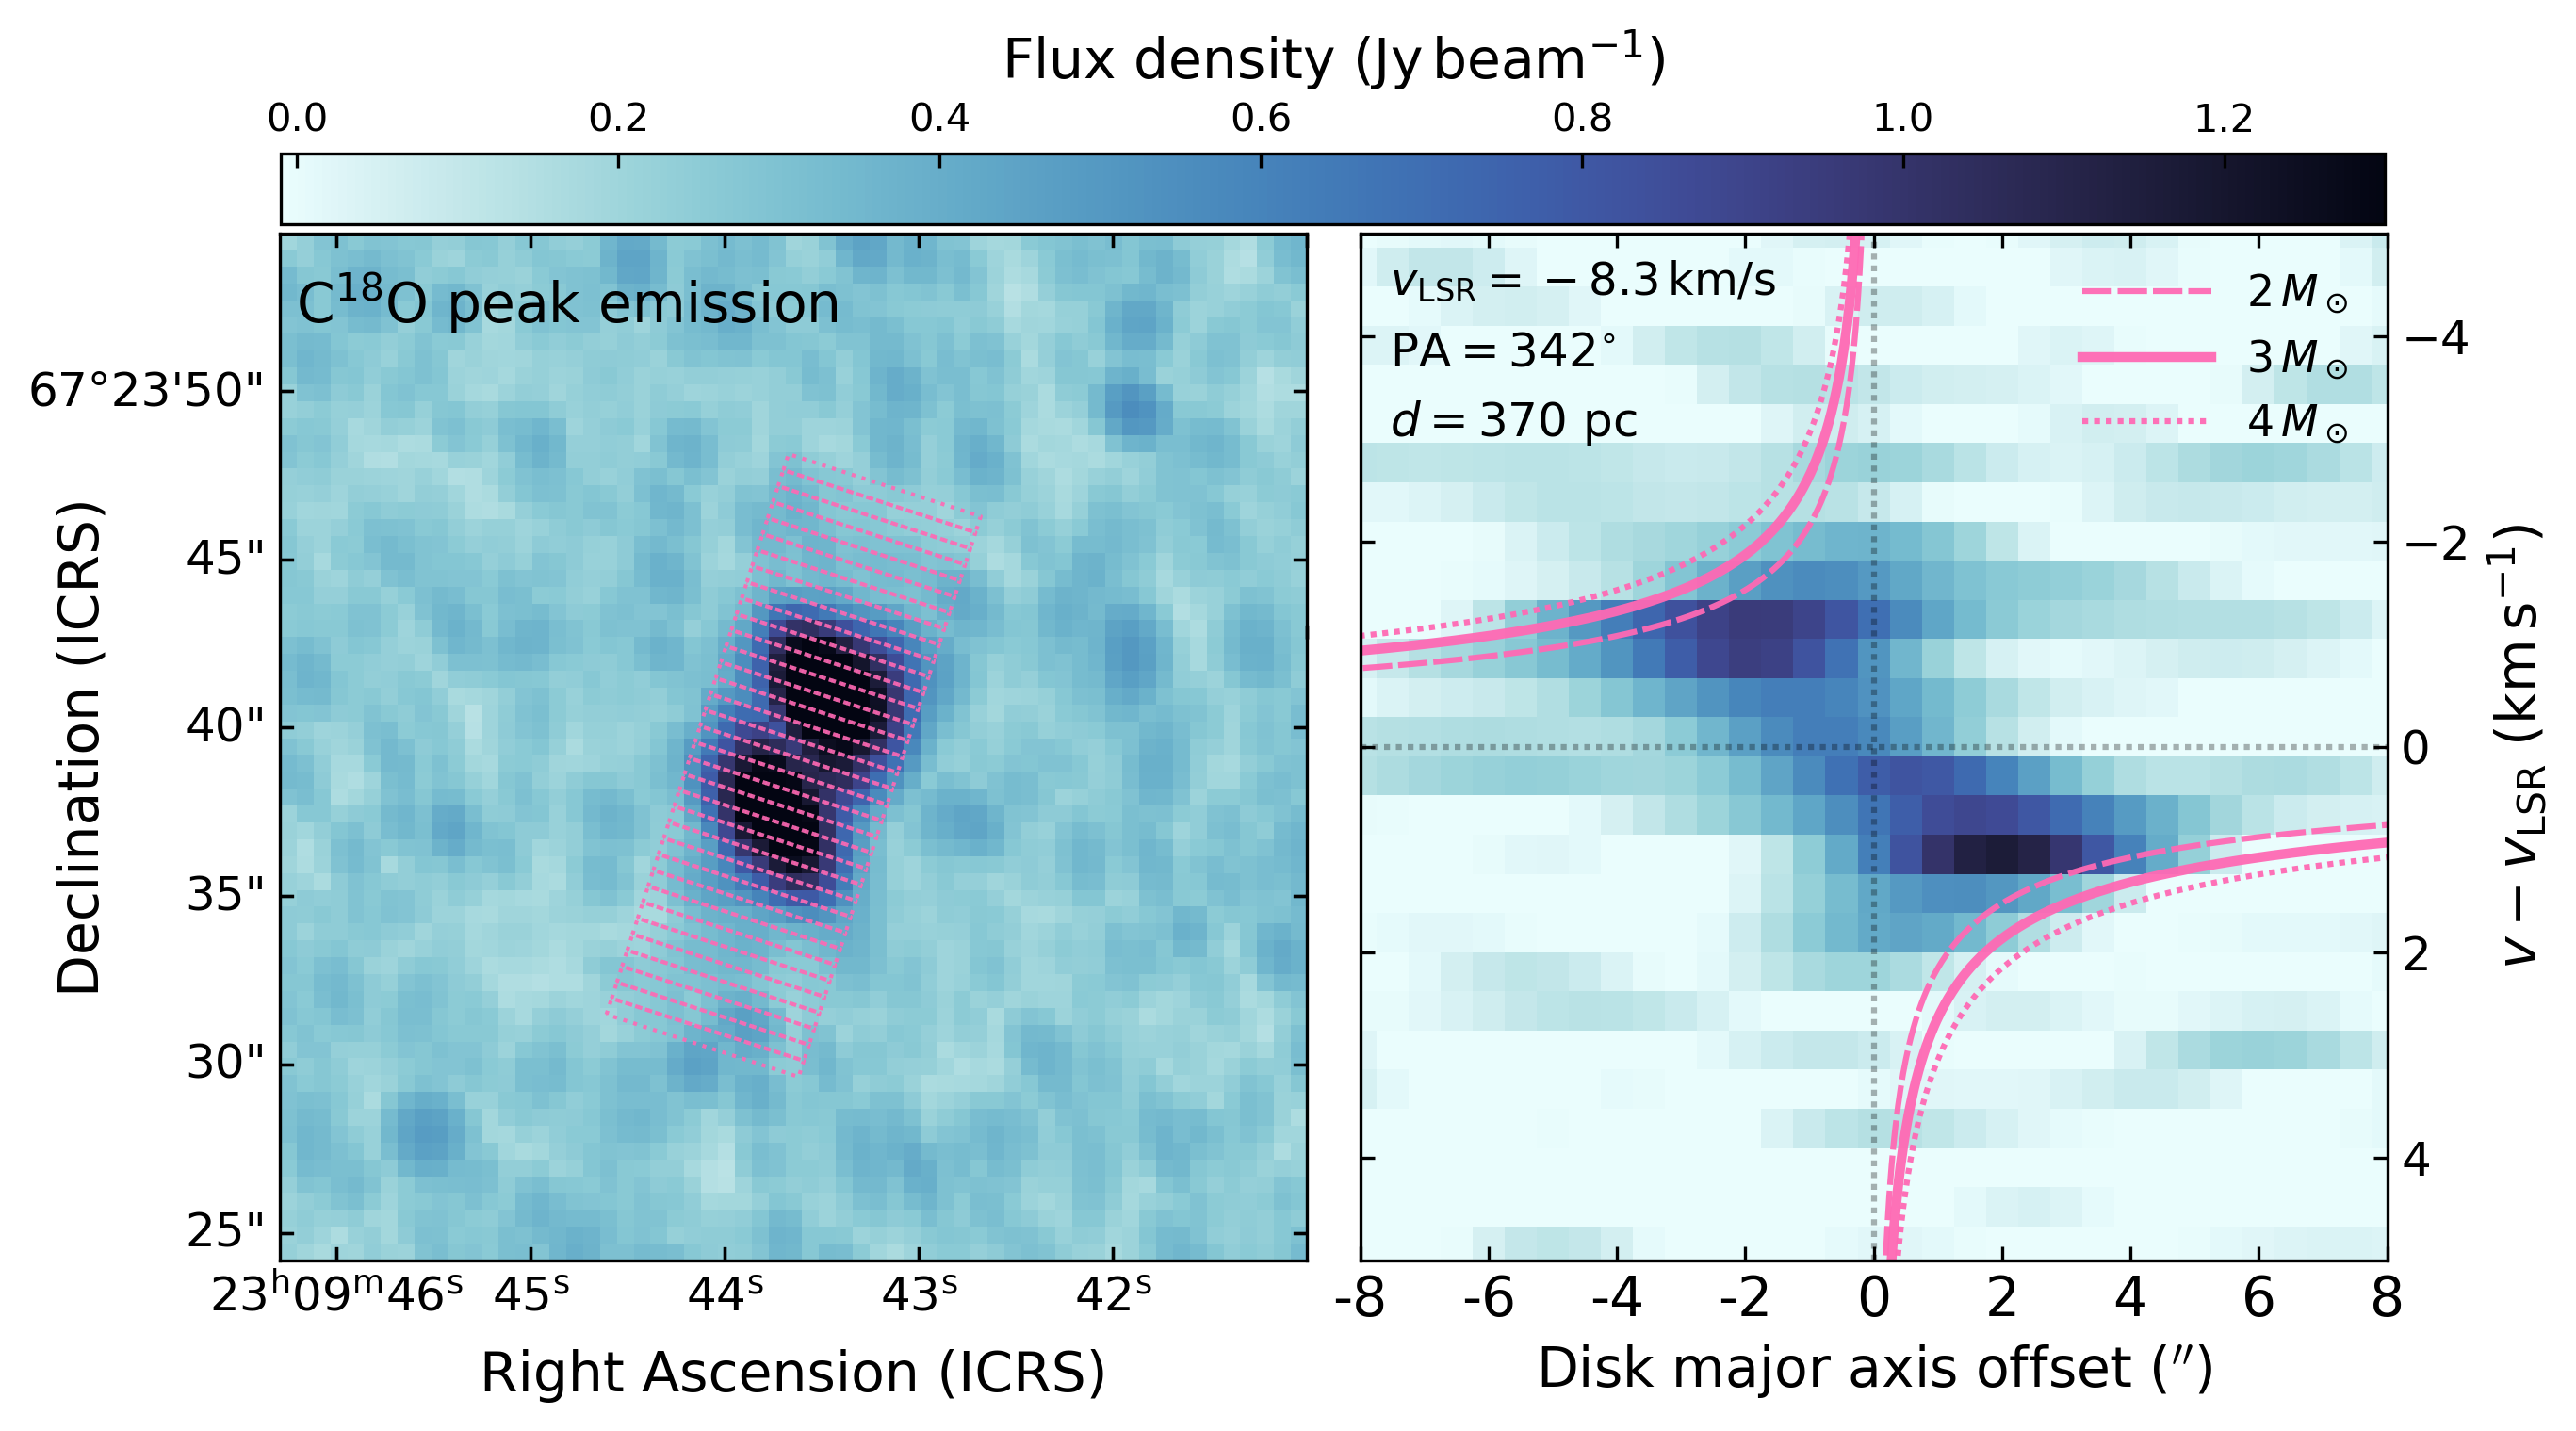

In [30]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cmocean 
import cmasher as cmr
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

### C18O peak emission
#color_table = plt.get_cmap('cmr.eclipse')   # MPL
color_table=cmocean.cm.ice_r
# so the slit is plotted on the scattered light image BUT the pv diagram was computed along the spectral cube


fig = plt.figure(layout="constrained", dpi=300, figsize=(9,5))
fig.subplots_adjust(wspace=0.05)

gs = GridSpec(1, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0], projection=cutout_cube.wcs.celestial)
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[0, 1])


ax1.tick_params(axis="both", direction="in")

vmin, vmax = -0.01, 1.3
ax1.imshow(cutout_cube.max(axis=0).value, cmap=color_table, vmin=vmin, vmax=vmax)
Path2.show_on_axis(ax=ax1, spacing=1, edgecolor='hotpink', linestyle=':', linewidth=1, alpha=0.9)

ww = wcs.WCS(cutout_cube[0].header)
ax1.set_xlabel(f"Right Ascension (ICRS)", fontsize=14)
ax1.set_ylabel(f"Declination (ICRS)", fontsize=14, labelpad=-1)

ax1.tick_params(axis='both', which='both', color='black', labelsize=12)
fig. text(0.11,0.85, s='C$^{18}$O peak emission', c='black', size=14)


### PV diagram
v_sys = -8.3 #u.km/u.s # got this value from eddy
pos_mid = 9. #arcsec; length of the vector is 18 arcsec

# x-axis has len=35
vel_arr = np.linspace(0,34,35)*pos_pixscale + pos_zero - x_mid 
# y-axis has len=60
pos_arr = np.linspace(0,59,60)*vel_pixscale + vel_zero - v_sys

xi, yi = np.meshgrid(vel_arr, pos_arr)
zi = pvdiagram2.data

im = ax2.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=color_table, linewidth=0,rasterized=True, vmin=vmin, vmax=vmax)

ax2.invert_yaxis()

ax2.set_xlabel("Disk major axis offset ($''$)", fontsize=14)
ax2.set_ylabel(r"$v-v_\mathrm{LSR}$ (km$\,\mathrm{{s}}^{{-1}}$)", fontsize=14)

ax2.axvline(0, c='black', ls=(0, (1, 1)), alpha=0.3)
ax2.axhline(0, c='black', ls=(0, (1, 1)), alpha=0.3)

ax2.set_ylim(5,-5)
ax2.set_xlim(8, -8)

ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.tick_params(axis='both', which='both', direction="in", left=True, right=True, top=True, bottom=True, color='black', labelsize=12)

ax2.set_aspect(1.6)

ax2.set_xticks(np.arange(-8,10,2), labels=np.arange(-8,10,2), fontsize=14)
#ax2.set_xticks([-4.4,-6.4, -8.5, -10.4, -12.4], labels=['+4', '+2', '0', '-2', '-4' ], fontsize=14)
ax2.invert_xaxis()

# rainbow_r colormap starts at red
#cmr.neon
masses = np.arange(2,5,1)
colors = ['hotpink', 'hotpink', 'hotpink', 'hotpink', 'hotpink']
radii = np.linspace(0,20,1000) #arcsec

linestyles = [(0, (5, 1)), '-', (0, (1, 1))]
linewidths = [1.5,2.5,1.5]
 
# overplot Kepler velocity profiles
for el in range(len(masses)):
    plt.plot(radii, kepler(mass=np.round(masses[el],2), radius=radii, distance=370., inclination=80.), c=colors[el], alpha=0.95, lw=linewidths[el], ls=linestyles[el], label='${0}\,M_\odot$'.format(np.round(masses[el],2)))#, path_effects=[pe.Stroke(linewidth=3, foreground='white'), pe.Normal()])
    plt.plot(-radii, -kepler(mass=np.round(masses[el],2), radius=radii, distance=370., inclination=80.), c=colors[el], alpha=0.95, lw=linewidths[el], ls=linestyles[el])#, path_effects=[pe.Stroke(linewidth=3, foreground='white'), pe.Normal()])

ax2.legend(loc='upper right', framealpha=0., labelcolor='black', fontsize=11, handlelength=3)

cb_ax = fig.add_axes([0.104, 0.92, 0.827, 0.05]) #right, top, length, thickness, 
cbar = fig.colorbar(im, cax=cb_ax, orientation='horizontal')
cbar.ax.tick_params(axis='x', direction='in')
cbar.ax.xaxis.set_ticks_position("top")
cbar.set_label('Flux density $(\mathrm{Jy\,beam^{-1}})$', fontsize=14, labelpad=-50)

#cb = fig.colorbar(im, ax=ax2, orientation='horizontal', pad=-10)
#cb.set_label(label='Flux density $(\mathrm{Jy\,beam}^{-1}$)', fontsize=13)
fig.text(0.54,0.87, s=r'$v_\mathrm{{LSR}}={0}\,\mathrm{{km/s}}$'.format(v_sys), c='black', size=11.5)
fig.text(0.54,0.82, s=r'PA$=342^{{\circ}}$', c='black', size=12)
fig.text(0.54,0.77, s=r'$d=370$ pc', c='black', size=12)


#fig.tight_layout()

fig.savefig('../plots/paper_plots/pv_diagram_C18O_2.pdf', bbox_inches='tight')


This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
divide by zero encountered in divide


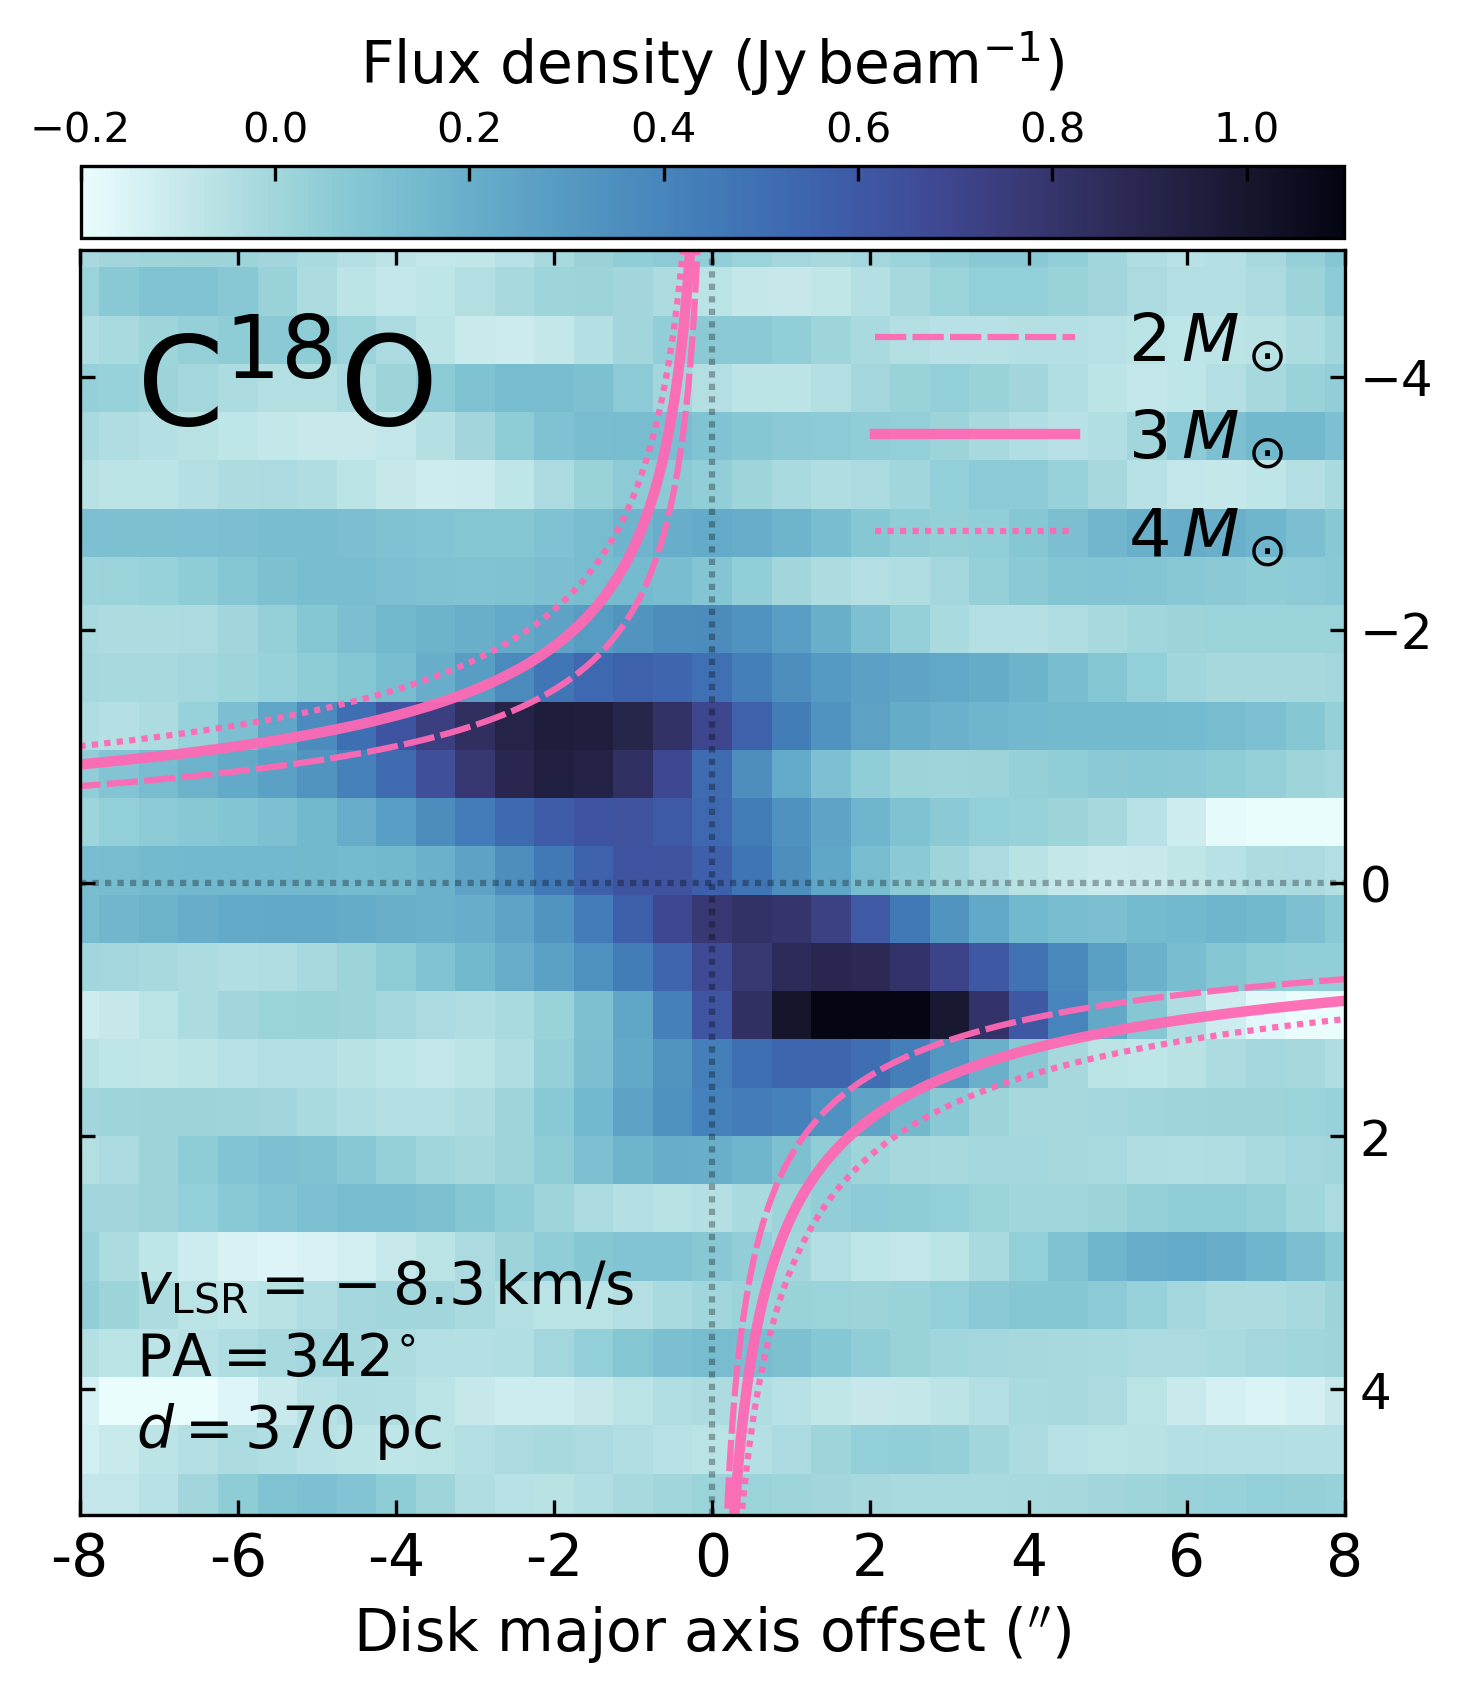

In [33]:
fig = plt.figure(layout="constrained", dpi=300)
fig.subplots_adjust(wspace=0.05)

gs = GridSpec(1, 1, figure=fig)
ax2 = fig.add_subplot(gs[0, 0])

vmin, vmax = -0.2, 1.1

### PV diagram
v_sys = -8.3 #u.km/u.s # got this value from eddy
pos_mid = 9. #arcsec; length of the vector is 18 arcsec

# x-axis has len=35
vel_arr = np.linspace(0,34,35)*pos_pixscale + pos_zero - x_mid 
# y-axis has len=60
pos_arr = np.linspace(0,59,60)*vel_pixscale + vel_zero - v_sys

xi, yi = np.meshgrid(vel_arr, pos_arr)
zi = pvdiagram2.data

im = ax2.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=color_table, linewidth=0,rasterized=True, vmin=vmin, vmax=vmax)

ax2.invert_yaxis()

ax2.set_xlabel("Disk major axis offset ($''$)", fontsize=14)
ax2.set_ylabel(r"", fontsize=14)
#ax2.set_yticklabels([])

ax2.axvline(0, c='black', ls=(0, (1, 1)), alpha=0.3)
ax2.axhline(0, c='black', ls=(0, (1, 1)), alpha=0.3)

ax2.set_ylim(5,-5)
ax2.set_xlim(8, -8)

ax2.yaxis.set_label_position("left")
ax2.yaxis.tick_right()
ax2.tick_params(axis='both', which='both', direction="in", left=True, right=True, top=True, bottom=True, color='black', labelsize=12)

ax2.set_aspect(1.6)

ax2.set_xticks(np.arange(-8,10,2), labels=np.arange(-8,10,2), fontsize=14)
#ax2.set_xticks([-4.4,-6.4, -8.5, -10.4, -12.4], labels=['+4', '+2', '0', '-2', '-4' ], fontsize=14)
ax2.invert_xaxis()

# rainbow_r colormap starts at red
#cmr.neon
masses = np.arange(2,5,1)
colors = ['hotpink', 'hotpink', 'hotpink', 'hotpink', 'hotpink']
radii = np.linspace(0,20,1000) #arcsec

linestyles = [(0, (5, 1)), '-', (0, (1, 1))]
linewidths = [1.5,2.5,1.5]
 
# overplot Kepler velocity profiles
for el in range(len(masses)):
    plt.plot(radii, kepler(mass=np.round(masses[el],2), radius=radii, distance=370., inclination=80.), c=colors[el], alpha=0.95, lw=linewidths[el], ls=linestyles[el], label='${0}\,M_\odot$'.format(np.round(masses[el],2)))#, path_effects=[pe.Stroke(linewidth=3, foreground='white'), pe.Normal()])
    plt.plot(-radii, -kepler(mass=np.round(masses[el],2), radius=radii, distance=370., inclination=80.), c=colors[el], alpha=0.95, lw=linewidths[el], ls=linestyles[el])#, path_effects=[pe.Stroke(linewidth=3, foreground='white'), pe.Normal()])

ax2.legend(loc='upper right', framealpha=0., labelcolor='black', fontsize=16, handlelength=3)

cb_ax = fig.add_axes([0.171, 1., 0.658, 0.05]) #right, top, length, thickness, 
cbar = fig.colorbar(im, cax=cb_ax, orientation='horizontal')
cbar.ax.tick_params(axis='x', direction='in')
cbar.ax.xaxis.set_ticks_position("top")
cbar.set_label('Flux density $(\mathrm{Jy\,beam^{-1}})$', fontsize=14, labelpad=-50)

#cb = fig.colorbar(im, ax=ax2, orientation='horizontal', pad=-10)
#cb.set_label(label='Flux density $(\mathrm{Jy\,beam}^{-1}$)', fontsize=13)
fig.text(0.2,0.87, s='C$^{18}$O', c='black', size=30)
fig.text(0.2,0.26, s=r'$v_\mathrm{{LSR}}={0}\,\mathrm{{km/s}}$'.format(v_sys), c='black', size=14)
fig.text(0.2,0.21, s=r'PA$=342^{{\circ}}$', c='black', size=14)
fig.text(0.2,0.16, s=r'$d=370$ pc', c='black', size=14)


#fig.tight_layout()

fig.savefig('../plots/paper_plots/pv_diagram_C18O_small.pdf', bbox_inches='tight')


This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
This function (<function BaseSpectralCube.max at 0x12f0ef520>) requires loading the entire cube into memory and may therefore be slow.
Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
Arithmetic beam averaging is being performed.  This is not a mathematically robust operation, but is being permitted because the beams differ by <0.01
divide by zero encountered in divide


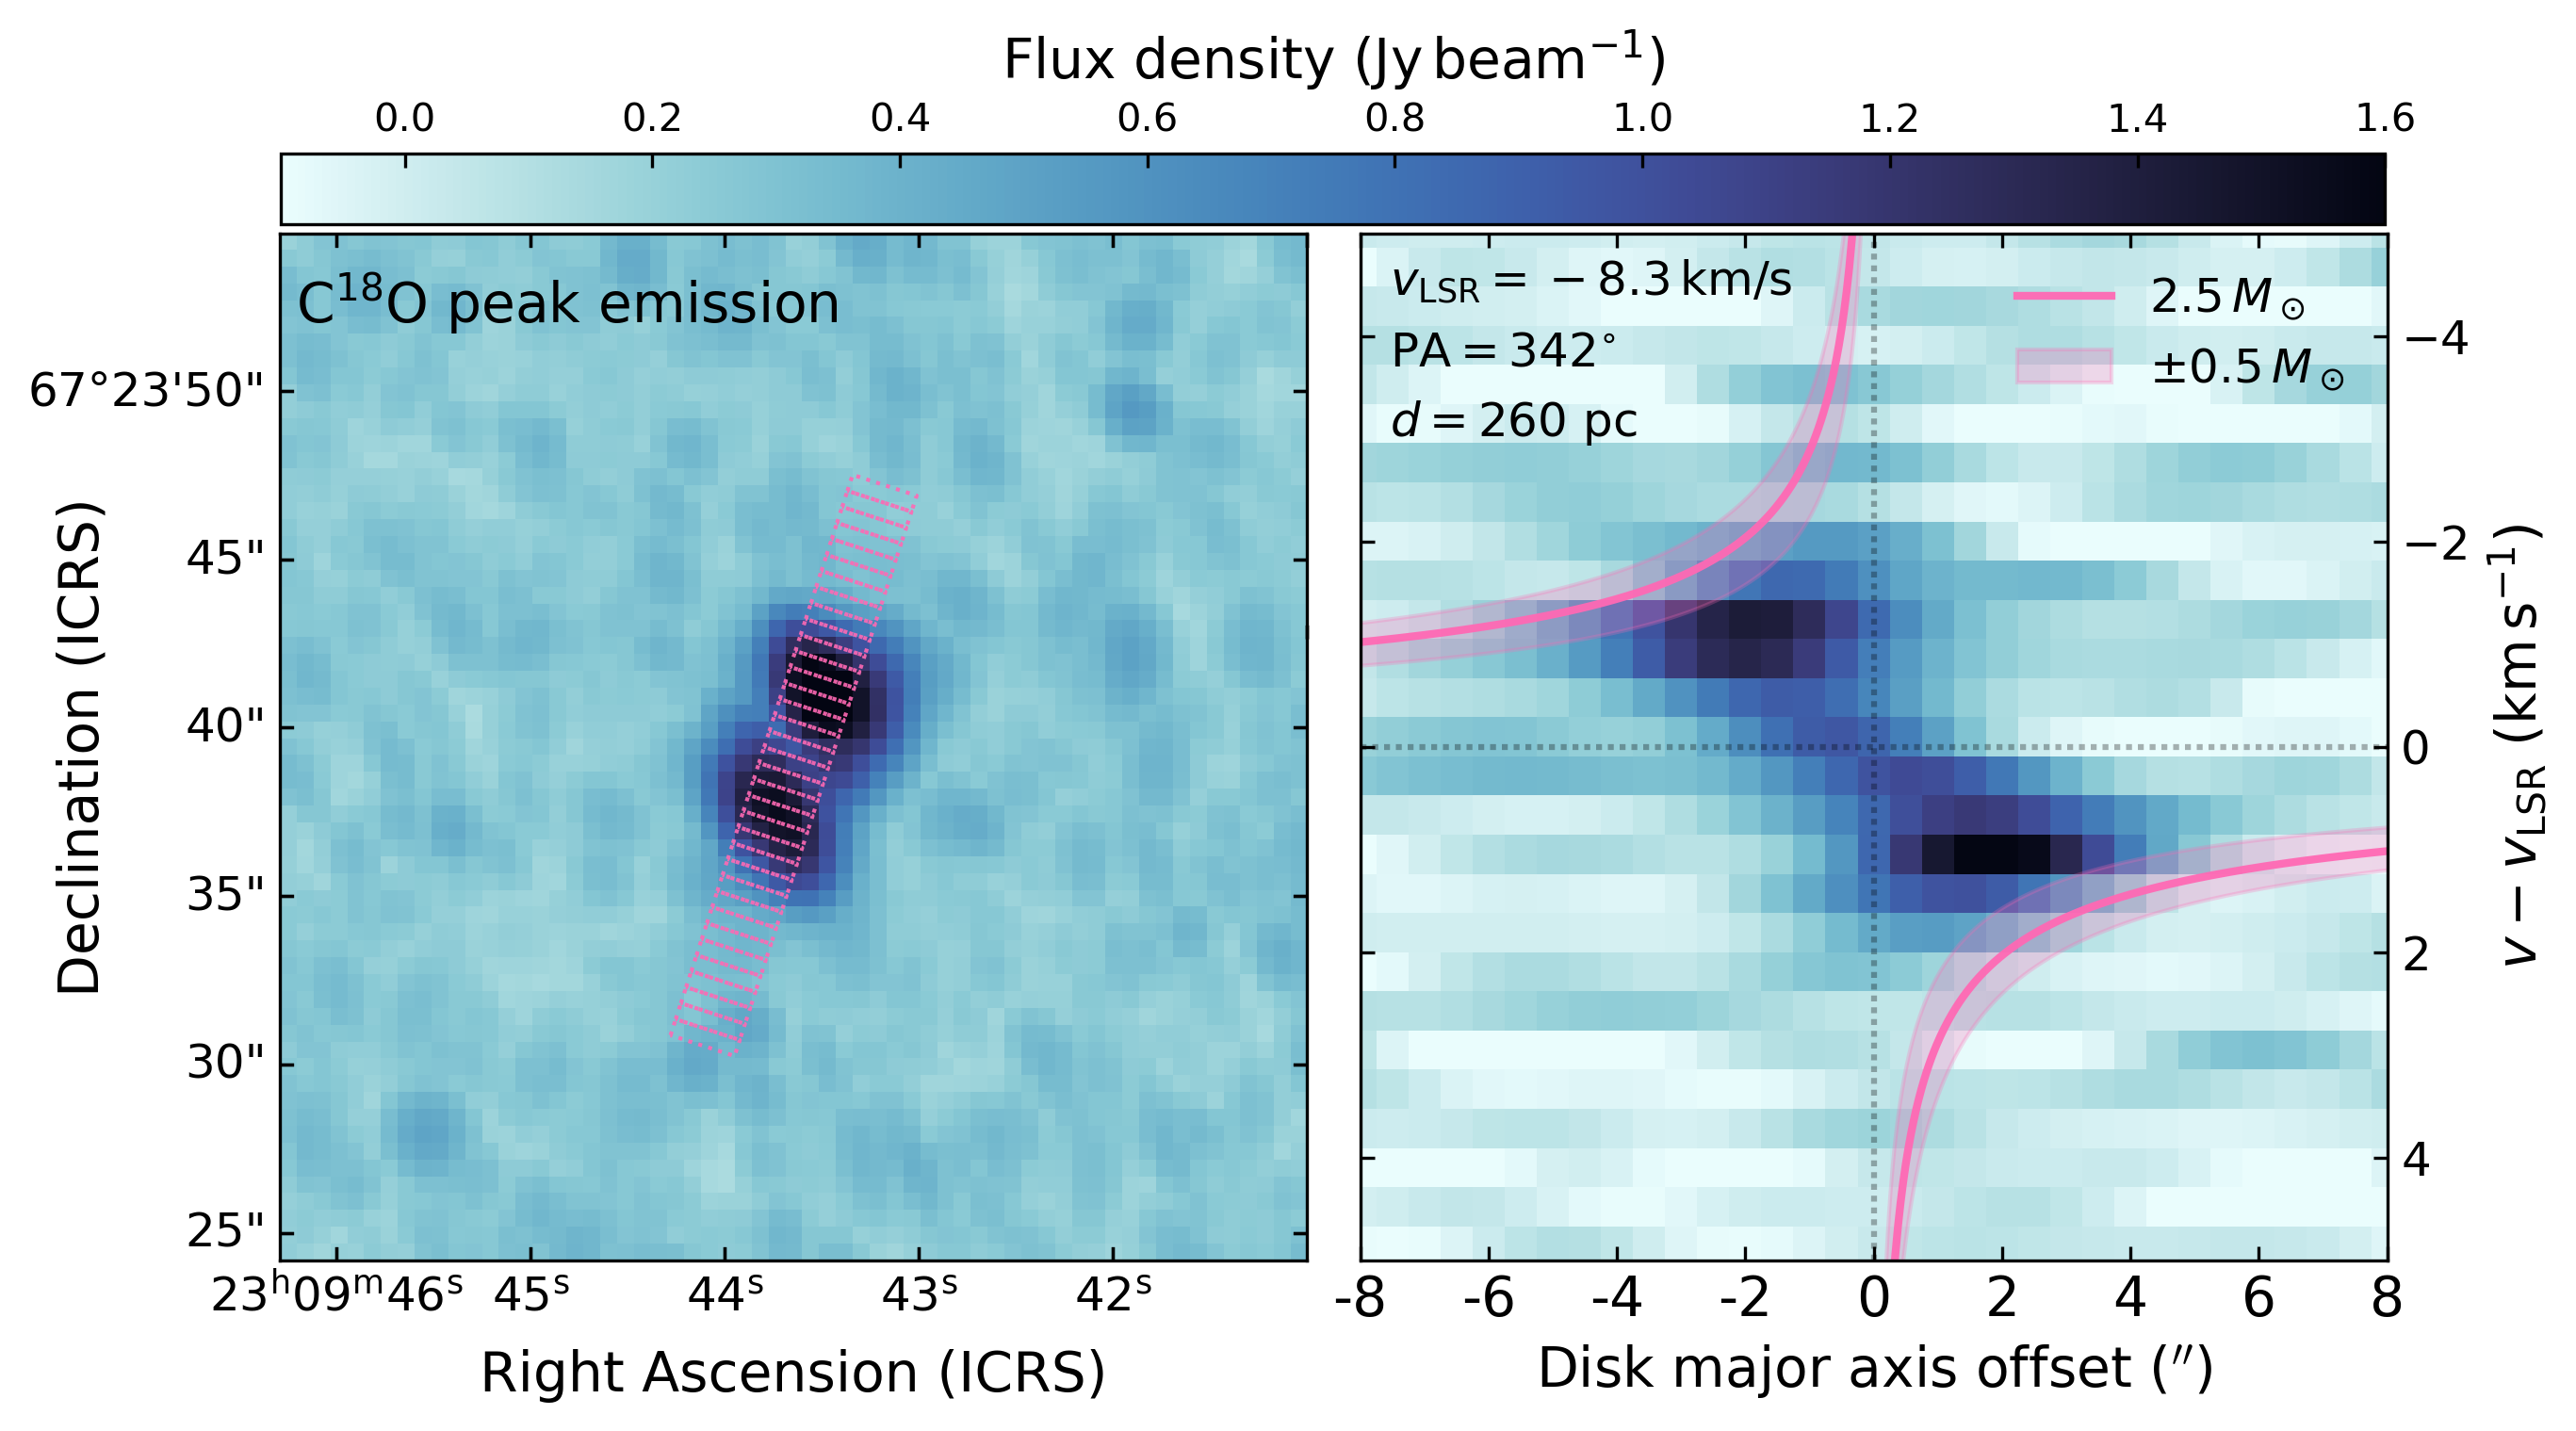

In [22]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cmocean 
import cmasher as cmr
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

### C18O peak emission
#color_table = plt.get_cmap('cmr.eclipse')   # MPL
color_table=cmocean.cm.ice_r
# so the slit is plotted on the scattered light image BUT the pv diagram was computed along the spectral cube


fig = plt.figure(layout="constrained", dpi=300, figsize=(9,5))
fig.subplots_adjust(wspace=0.05)

gs = GridSpec(1, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0], projection=cutout_cube.wcs.celestial)
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[0, 1])


ax1.tick_params(axis="both", direction="in")

vmin, vmax = -0.1, 1.6
ax1.imshow(cutout_cube.max(axis=0).value, cmap=color_table, vmin=vmin, vmax=vmax)
Path2.show_on_axis(ax=ax1, spacing=1, edgecolor='hotpink', linestyle=':', linewidth=1, alpha=0.9)

ww = wcs.WCS(cutout_cube[0].header)
ax1.set_xlabel(f"Right Ascension (ICRS)", fontsize=14)
ax1.set_ylabel(f"Declination (ICRS)", fontsize=14, labelpad=-1)

ax1.tick_params(axis='both', which='both', color='black', labelsize=12)
fig. text(0.11,0.85, s='C$^{18}$O peak emission', c='black', size=14)


### PV diagram
v_sys = -8.3 #u.km/u.s # got this value from eddy
pos_mid = 9. #arcsec; length of the vector is 18 arcsec

# x-axis has len=35
vel_arr = np.linspace(0,34,35)*pos_pixscale + pos_zero - x_mid 
# y-axis has len=60
pos_arr = np.linspace(0,59,60)*vel_pixscale + vel_zero - v_sys

xi, yi = np.meshgrid(vel_arr, pos_arr)
zi = pvdiagram2.data

im = ax2.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=color_table, linewidth=0,rasterized=True, vmin=vmin, vmax=vmax)

ax2.invert_yaxis()

ax2.set_xlabel("Disk major axis offset ($''$)", fontsize=14)
ax2.set_ylabel(r"$v-v_\mathrm{LSR}$ (km$\,\mathrm{{s}}^{{-1}}$)", fontsize=14)

ax2.axvline(0, c='black', ls=(0, (1, 1)), alpha=0.3)
ax2.axhline(0, c='black', ls=(0, (1, 1)), alpha=0.3)

ax2.set_ylim(5,-5)
ax2.set_xlim(8, -8)

ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.tick_params(axis='both', which='both', direction="in", left=True, right=True, top=True, bottom=True, color='black', labelsize=12)

ax2.set_aspect(1.6)

ax2.set_xticks(np.arange(-8,10,2), labels=np.arange(-8,10,2), fontsize=14)
#ax2.set_xticks([-4.4,-6.4, -8.5, -10.4, -12.4], labels=['+4', '+2', '0', '-2', '-4' ], fontsize=14)
ax2.invert_xaxis()

# rainbow_r colormap starts at red
#cmr.neon
masses = np.arange(1.5,4,0.5)
colors = ['black', 'black', 'hotpink', 'black', 'black']
radii = np.linspace(0,20,1000) #arcsec

linestyles = [(0, (5, 5)), (0, (3, 5, 1, 5)), '-', (0, (3, 1, 1, 1)), (0, (5, 1))]

# overplot Kepler velocity profiles
plt.plot(radii, kepler(mass=2.5, radius=radii, distance=370., inclination=80.), c='hotpink', alpha=0.95, lw=2, ls='-', label='$2.5\,M_\odot$')
plt.plot(-radii, -kepler(mass=2.5, radius=radii, distance=370., inclination=80.), c='hotpink', alpha=0.95, lw=2, ls='-')

#plt.fill_between(radii, kepler(mass=2, radius=radii, distance=370., inclination=80.).value, kepler(mass=3, radius=radii, distance=370., inclination=80.).value, color='hotpink', alpha=0.3)
#plt.fill_between(-radii, -kepler(mass=2, radius=radii, distance=370., inclination=80.).value, -kepler(mass=3, radius=radii, distance=370., inclination=80.).value, color='hotpink', alpha=0.3)

plt.fill_between(radii, kepler(mass=1.5, radius=radii, distance=370., inclination=80.).value, kepler(mass=3.5, radius=radii, distance=370., inclination=80.).value, color='hotpink', alpha=0.25, label='$\pm0.5\,M_\odot$')
plt.fill_between(-radii, -kepler(mass=1.5, radius=radii, distance=370., inclination=80.).value, -kepler(mass=3.5, radius=radii, distance=370., inclination=80.).value, color='hotpink', alpha=0.25)

ax2.legend(loc='upper right', framealpha=0., labelcolor='black', fontsize=12, handlelength=2)

cb_ax = fig.add_axes([0.104, 0.92, 0.827, 0.05]) #right, top, length, thickness, 
cbar = fig.colorbar(im, cax=cb_ax, orientation='horizontal')
cbar.ax.tick_params(axis='x', direction='in')
cbar.ax.xaxis.set_ticks_position("top")
cbar.set_label('Flux density $(\mathrm{Jy\,beam^{-1}})$', fontsize=14, labelpad=-50)

#cb = fig.colorbar(im, ax=ax2, orientation='horizontal', pad=-10)
#cb.set_label(label='Flux density $(\mathrm{Jy\,beam}^{-1}$)', fontsize=13)
fig.text(0.54,0.87, s=r'$v_\mathrm{{LSR}}={0}\,\mathrm{{km/s}}$'.format(v_sys), c='black', size=12)
fig.text(0.54,0.82, s=r'PA$=342^{{\circ}}$', c='black', size=12)
fig.text(0.54,0.77, s=r'$d=370$ pc', c='black', size=12)


#fig.tight_layout()

fig.savefig('../plots/paper_plots/pv_diagram_C18O.pdf', bbox_inches='tight')


## Get the pixel scales of the PV diagram

In [33]:
from astropy import wcs

# x-axis = offset in deg
# y-axis = velocity in m/s
ww2 = wcs.WCS(pvdiagram2)

wcs.utils.proj_plane_pixel_scales(ww2)
## 0.5 arcsec per pixel
print(wcs.utils.proj_plane_pixel_scales(ww2)[0]*60*60)
x_pixelscale_arcsec = wcs.utils.proj_plane_pixel_scales(ww2)[0]*60*60
x_pixelscale_deg = wcs.utils.proj_plane_pixel_scales(ww2)[0]

## km/s per pixel
print(wcs.utils.proj_plane_pixel_scales(ww2)[1]/1000)

0.50000000000004
0.38135861116765
